In [ ]:
#Data source: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

<h2>Loading Data</h2>

In [2]:
#Loading
train = pd.read_csv('../Desktop/house/train.csv')
test = pd.read_csv('../Desktop/house/test.csv')

#Storing the test index for later
min_test_id = min(test['Id'])

#Setting Id column as index
train = train.set_index('Id')
test = test.set_index('Id')

<h2>Preprocessing</h2>

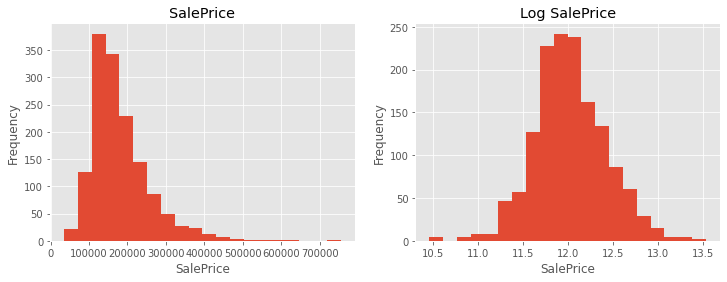

In [3]:
#Target normal vs. log
col = 'SalePrice'
fig, [ax1, ax2] = plt.subplots(1,2, figsize = (12,4))
ax1.hist(train[col], bins = 20)
ax2.hist(np.log(train[col]+1), bins = 20)
ax1.set_xlabel(col)
ax2.set_xlabel(col)
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Frequency')
ax1.set_title(col)
ax2.set_title('Log ' + col)
plt.show()

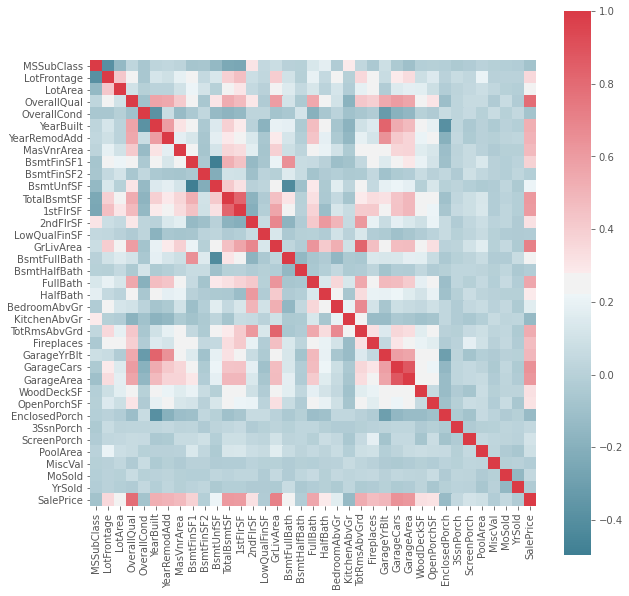

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
SalePrice,-0.084284,0.351799,0.263843,0.790982,-0.077856,0.522897,0.507101,0.477493,0.38642,-0.011378,...,0.324413,0.315856,-0.128578,0.044584,0.111447,0.092404,-0.02119,0.046432,-0.028923,1.0


In [4]:
#Correlation matrix
f, ax = plt.subplots(figsize=(10, 10))
corr = train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

corr = train.corr()['SalePrice'].sort_values(ascending = False)
train.corr()[-1:]

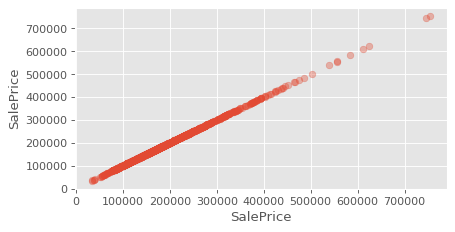

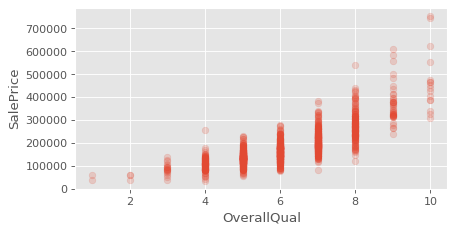

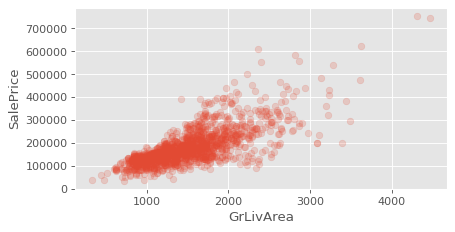

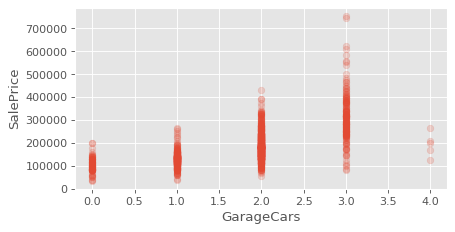

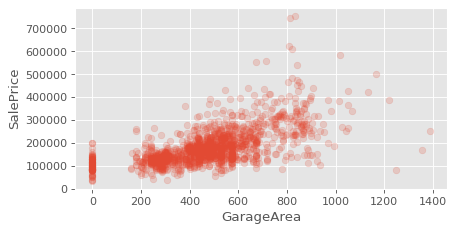

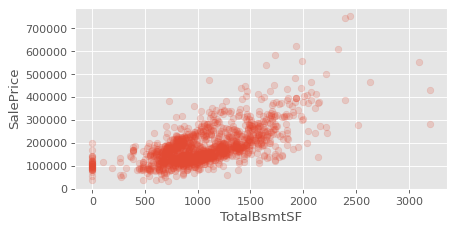

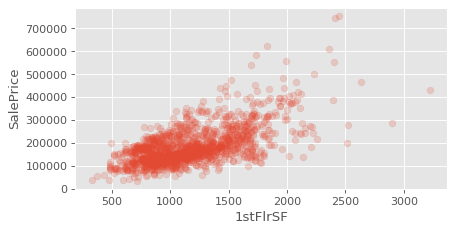

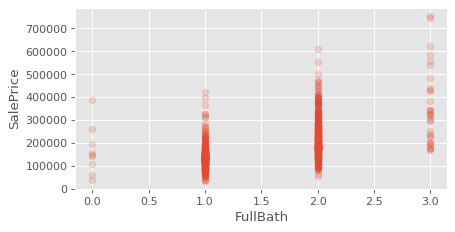

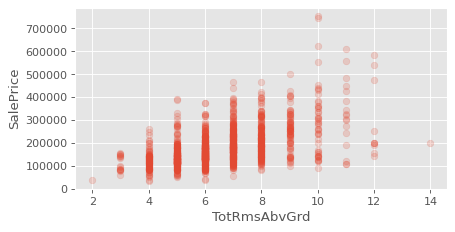

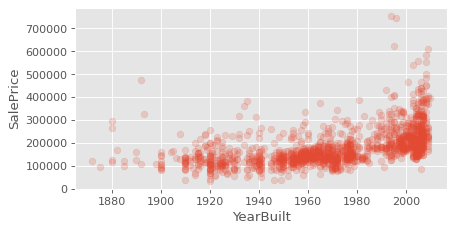

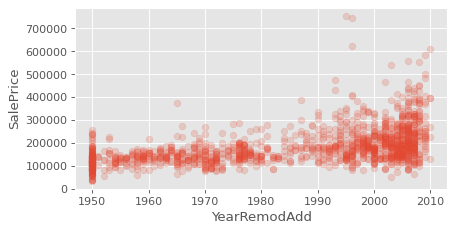

In [18]:
num_features_names = list(corr[corr>0.5].index)
target_name = 'SalePrice'

for col in num_features_names:
    plot_df = train[[col, target_name]].dropna()
    fig, ax = plt.subplots(figsize=(6,3), dpi=80)
    ax.scatter(plot_df[col], plot_df[target_name], alpha = 0.2)
    plt.xlabel(col)
    plt.ylabel(target_name)
    plt.show()

In [6]:
#Cleaning outliers
train = train.drop(
    train[(train['OverallQual']==10) & (train['SalePrice']<200000)].index)

#Dropping features with too many missing values
missing = train.isna().sum().sort_values(ascending = False)
train = train.drop(train[list(missing[missing > 100].index)], axis=1)

<h2>Feature Engineering</h2>

In [7]:
data = train.append(test)
data['GarageCars'] = np.where(data['GarageCars']>3, 3, data['GarageCars'])
data['FullBath'] = np.where(data['FullBath']>3, 3, data['FullBath'])
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

In [8]:
#Numeric features
num_features = data[['GarageCars','OverallQual','TotalSF']]

In [9]:
#Categorical features
cat_feature_cols = ['Electrical','SaleType','KitchenQual','Exterior1st','Exterior2nd','Functional','Utilities','MSZoning']
for col in cat_feature_cols:
    data[col] = data[col].fillna(data[col].mode())

#Numeric features to make binary
make_binary = ['MasVnrArea','BsmtFinSF1','2ndFlrSF','Fireplaces','GarageArea','WoodDeckSF','OpenPorchSF']
for col in make_binary:
    data['has_' + col] = np.where(data[col]>0, 1, 0)
    cat_feature_cols.append('has_' + col)
    
cat_features = data[cat_feature_cols]
cat_features_dummies = pd.get_dummies(cat_features)   

In [10]:
#Final features
features = pd.concat([num_features, cat_features_dummies], axis = 1)
print("Features:",features.shape[1])
print("Rows:",features.shape[0])

#Target
target = np.log(data['SalePrice'])

Features: 73
Rows: 2917


<h2>Prediction</h2>

In [25]:
#from sklearn.preprocessing import *
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
#from sklearn.pipeline import 
#from sklearn.compose import GridSearchCV

In [26]:
#Splitting real train and test data
X_train = features[features.index < min_test_id]
y_train = target[target.index < min_test_id]
X_test = features[features.index >= min_test_id].fillna(0.5)

In [27]:
#Testing models
cv = cross_val_score(LinearRegression(), X_train, y_train, cv=10)
print("LinearRegression:",np.mean(cv))

cv = cross_val_score(Ridge(alpha=0.1), X_train, y_train, cv=10)
print("Ridge:",np.mean(cv))

cv = cross_val_score(RandomForestRegressor(), X_train, y_train, cv=10)
print("RandomForestRegressor:",np.mean(cv))

cv = cross_val_score(GradientBoostingRegressor(), X_train, y_train, cv=10)
print("GradientBoostingRegressor:",np.mean(cv))

LinearRegression: 0.8738412189367691
Ridge: 0.8746908477559305
RandomForestRegressor: 0.855577961559676
GradientBoostingRegressor: 0.8726488126065076


<h2>Parameter Tuning</h2>

In [28]:
#Tuning Ridge model with grid search
alphas = np.array([0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 10, 15, 20])
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(X_train, y_train)

print(grid.best_estimator_)
print(grid.best_score_)

Ridge(alpha=4.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
0.8791312157493081


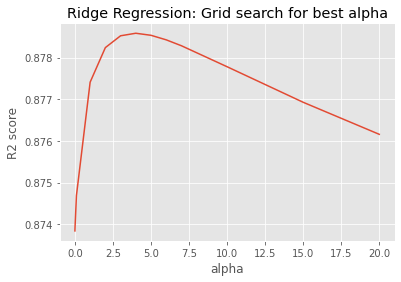

In [29]:
#Visualization of the grid search for better understanding
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 10, 15, 20]
scores = []
for i in alpha:
    cv = cross_val_score(Ridge(alpha=i), X_train, y_train, cv=10)
    scores.append(np.mean(cv))
    
plt.plot(alpha, scores)
plt.title('Ridge Regression: Grid search for best alpha')
plt.xlabel('alpha')
plt.ylabel('R2 score')
plt.show()

In [30]:
print('R2 score:', grid.best_score_)

R2 score: 0.8791312157493081


<h2>Submission</h2>

In [31]:
#Submission
y_pred = np.exp(grid.best_estimator_.predict(X_test))
submission = pd.DataFrame({'Id': features[features.index >= min_test_id].index, 'SalePrice': y_pred})
submission.to_csv('submission.csv', index=False)